### Create fake data

#### Pre-processing

In [1]:
import pandas as pd
from collections import defaultdict
import numpy as np
import seaborn as sns
from sdv.tabular import GaussianCopula
from sklearn.mixture import GaussianMixture
from sdv.sampling import Condition

In [2]:
claims_df = pd.read_csv("AFC_claims.csv")
# Dollars should be rounded to 2 decimals
claims_df["ClaimAmount"] = claims_df.ClaimAmount.round(2)
claims_df

BusinessID  ClaimAmount
0      00006A45    277674.57
1      00007A94    139775.41
2      0002A104    376145.26
3      0003A113     86434.20
4      0005A152    218156.43
...         ...          ...
8668   3A249916    469764.04
8669   0A249934     60665.72
8670   0A249935    235096.44
8671   6A249979    187283.83
8672   9A249983    259094.92

[8673 rows x 2 columns]

In [3]:
policies_df = pd.read_csv("AFC_policies.csv")
policies_df

BusinessID                                    BusinessType Province  \
0        000002A1                            photographic studios       ON   
1        000000A2                              massage therapists       QC   
2        000004A3                                 lawyers offices       ON   
3        000005A4                            optometrists offices       QC   
4        000001A5                          chiropractors' offices       ON   
...           ...                                             ...      ...   
249995   1A249996                            photographic studios       QC   
249996   8A249997                   automobile parking facilities       QC   
249997   3A249998                          arts and crafts stores       ON   
249998   3A249999                                    yoga studios       ON   
249999   5A250000  automobile repair shops and oil change centers       QC   

        Latitude  Longitude              City  AmountOfInsurance  Earnings  
0          45.09     -79.45       BRACEBRIDGE           416800.0   98000.0  
1          46.78     -71.26            QUEBEC           904600.0  406000.0  
2          46.52     -84.33  SAULT STE. MARIE           883300.0  157000.0  
3          45.56     -73.85             LAVAL           263400.0   86000.0  
4          43.14     -82.06            FOREST           706500.0  231000.0  
...          ...        ...               ...                ...       ...  
249995     45.45     -73.81     POINTE-CLAIRE           440300.0  293000.0  
249996     45.44     -75.74          GATINEAU           661400.0  264000.0  
249997     43.22     -79.91          HAMILTON           443300.0  210000.0  
249998     46.34     -79.47         NORTH BAY           780700.0  132000.0  
249999     45.39     -75.80          GATINEAU           977700.0  237000.0  

[250000 rows x 8 columns]

In [4]:
# Merge Province and City into Address
policies_df["Address"] = policies_df.Province + "," + policies_df.City
policies_df = policies_df.drop(columns=["Province", "City"])

# Set categorical features
policies_df.BusinessType = policies_df.BusinessType.astype("category")
policies_df.Address = policies_df.Address.astype("category")

# Select necessary columns for training and perform label encoding on categorical columns
policies_df["BusinessTypeCode"] = policies_df.BusinessType.cat.codes
# Top 10 encoding, top 1 to 9 address codes are encoded 1 to 9, others are encoded 0
top_addresses = list(policies_df.Address.cat.codes.value_counts().nlargest(9).index)
top_addresses_dict = defaultdict(int)
for idx, code in enumerate(top_addresses):
    top_addresses_dict[code] = idx+1
policies_df["AddressCode"] = policies_df.Address.cat.codes.map(top_addresses_dict)
policies_df = policies_df.drop(columns=["BusinessType", "Address"])

# Represent Earnings, AmountOfInsurance in 1000s of dollars, then take log to reduce skewness
policies_df.AmountOfInsurance /= 1000
policies_df.Earnings /= 1000
policies_df.AmountOfInsurance = np.log(policies_df.AmountOfInsurance)
policies_df.Earnings = np.log(policies_df.Earnings)

policies_df

BusinessID  Latitude  Longitude  AmountOfInsurance  Earnings  \
0        000002A1     45.09     -79.45           6.032606  4.584967   
1        000000A2     46.78     -71.26           6.807493  6.006353   
2        000004A3     46.52     -84.33           6.783665  5.056246   
3        000005A4     45.56     -73.85           5.573674  4.454347   
4        000001A5     43.14     -82.06           6.560323  5.442418   
...           ...       ...        ...                ...       ...   
249995   1A249996     45.45     -73.81           6.087456  5.680173   
249996   8A249997     45.44     -75.74           6.494359  5.575949   
249997   3A249998     43.22     -79.91           6.094247  5.347108   
249998   3A249999     46.34     -79.47           6.660191  4.882802   
249999   5A250000     45.39     -75.80           6.885203  5.468060   

        BusinessTypeCode  AddressCode  
0                     25            0  
1                     23            5  
2                     22            0  
3                     24            6  
4                     13            0  
...                  ...          ...  
249995                25            0  
249996                 8            1  
249997                 3            0  
249998                31            0  
249999                 9            1  

[250000 rows x 7 columns]

In [5]:
train_consolidated_df = claims_df.merge(policies_df, on="BusinessID", how="outer")

# Using ClaimAmount create NumClaims and ExpectedSeverity columns taking into account duplicate BusinessID rows
train_consolidated_df["DidClaim"] = train_consolidated_df.ClaimAmount > 0
# Treat number of claims as continuos variable
num_claims = train_consolidated_df.groupby("BusinessID").DidClaim.sum().astype(float)
num_claims.name = "NumClaims"
expected_severity = train_consolidated_df.groupby("BusinessID").ClaimAmount.mean()
expected_severity.name = "ExpectedSeverity"
train_consolidated_df = train_consolidated_df.merge(num_claims, on="BusinessID")
train_consolidated_df = train_consolidated_df.merge(expected_severity, on="BusinessID")

# Drop DidClaim, ClaimAmount column and remove duplicate rows
train_consolidated_df = train_consolidated_df.drop(columns=["DidClaim", "ClaimAmount"])
train_consolidated_df = train_consolidated_df.drop_duplicates("BusinessID")

# Represent ExpectedSeverity in 1000s of dollars, then take log to reduce skewness
train_consolidated_df.ExpectedSeverity /= 1000
train_consolidated_df.ExpectedSeverity = np.log(train_consolidated_df.ExpectedSeverity)

# Drop BusinessID
train_consolidated_df = train_consolidated_df.drop(columns=["BusinessID"])

train_consolidated_df

Latitude  Longitude  AmountOfInsurance  Earnings  BusinessTypeCode  \
0          43.90     -79.27           6.694067  4.682131                 8   
1          43.65     -79.43           6.535532  5.147494                14   
2          43.15     -80.24           6.778899  5.497168                25   
3          45.70     -73.63           6.139453  4.997212                23   
4          43.64     -79.76           6.919684  5.513429                23   
...          ...        ...                ...       ...               ...   
250196     45.45     -73.81           6.087456  5.680173                25   
250197     45.44     -75.74           6.494359  5.575949                 8   
250198     43.22     -79.91           6.094247  5.347108                 3   
250199     46.34     -79.47           6.660191  4.882802                31   
250200     45.39     -75.80           6.885203  5.468060                 9   

        AddressCode  NumClaims  ExpectedSeverity  
0                 0        1.0          5.626450  
1                 2        1.0          4.940037  
2                 0        1.0          5.929975  
3                 0        1.0          4.459383  
4                 0        1.0          5.385212  
...             ...        ...               ...  
250196            0        0.0               NaN  
250197            1        0.0               NaN  
250198            0        0.0               NaN  
250199            0        0.0               NaN  
250200            1        0.0               NaN  

[250000 rows x 8 columns]

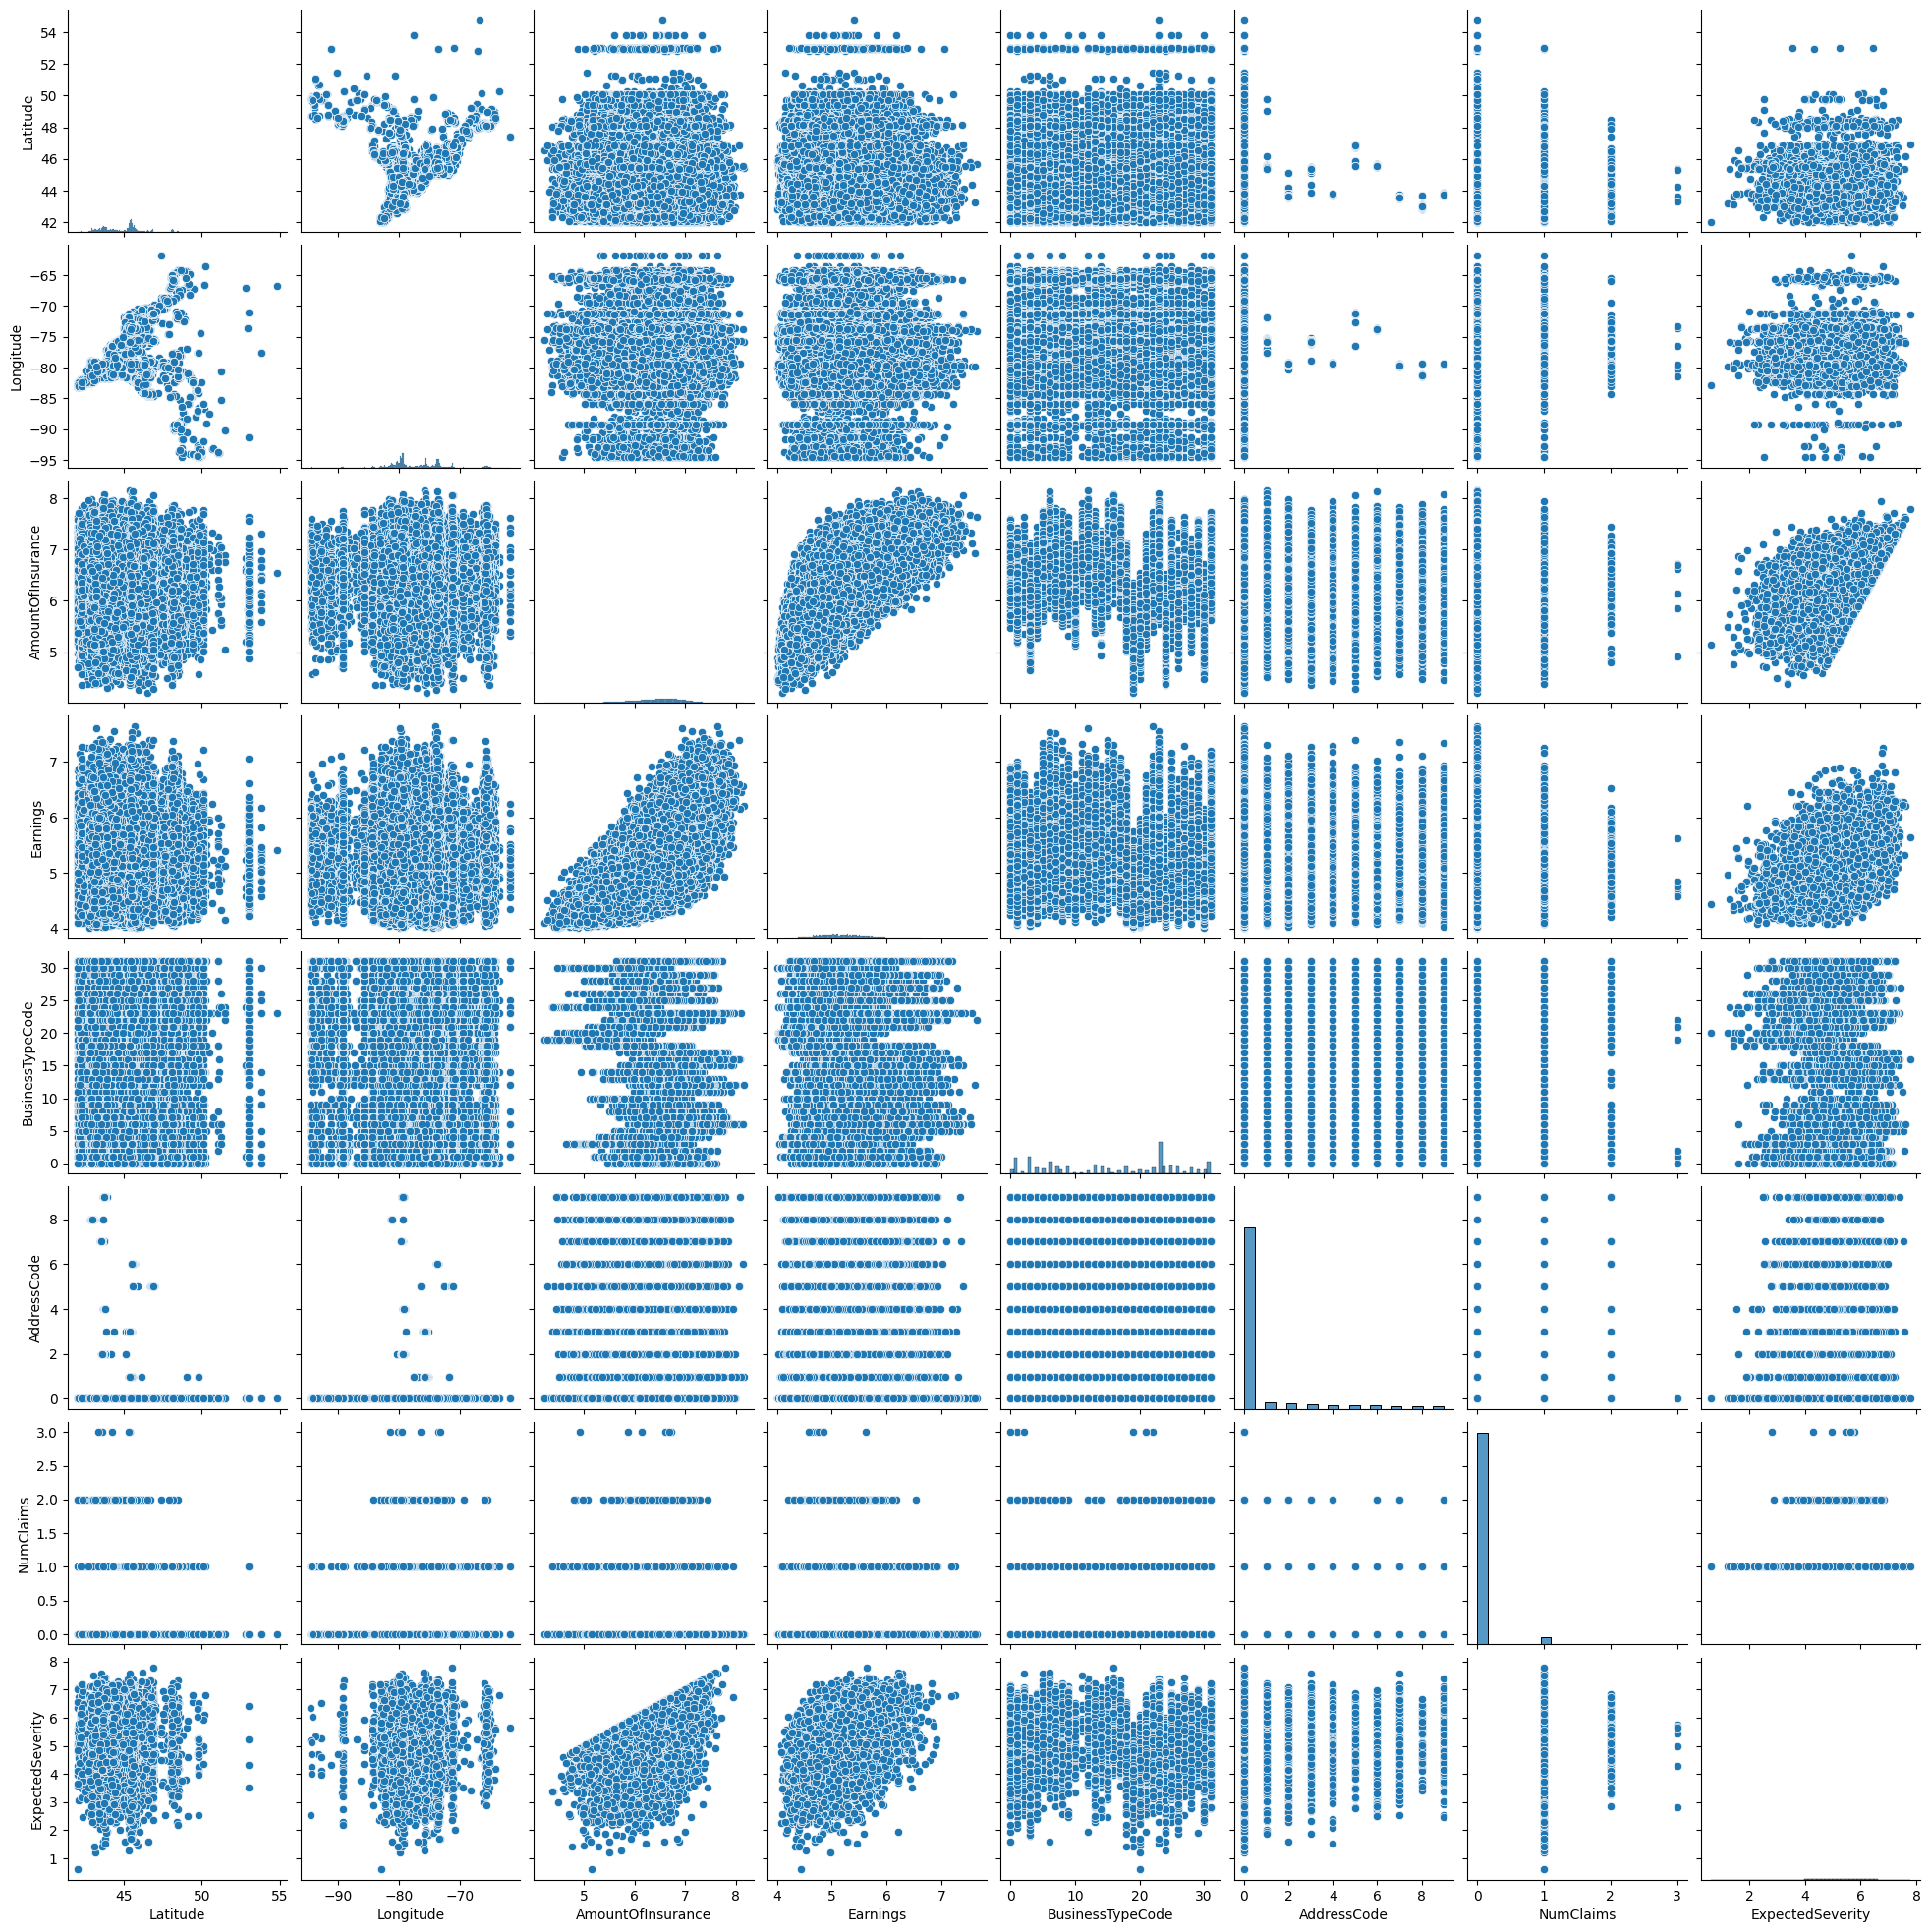

In [6]:
sns.pairplot(train_consolidated_df)

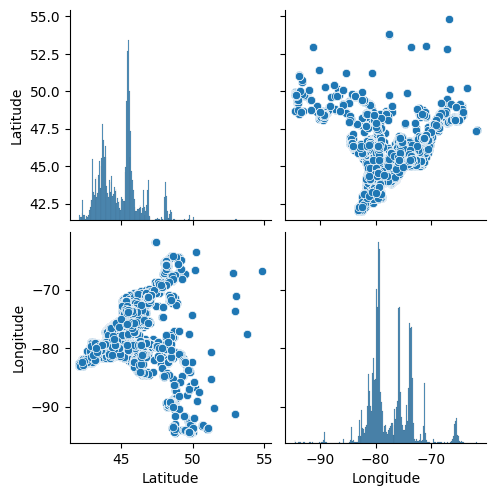

In [7]:
sns.pairplot(train_consolidated_df[["Latitude", "Longitude"]])

### Create rows with number of claims = 0 and severity = nan

In [8]:
# NumClaims model
X1 = train_consolidated_df.drop(columns=["ExpectedSeverity"])

In [9]:
# 13 components result in best BIC
for num_components in range(13, 14):
    gmm = GaussianMixture(n_components=num_components, random_state=1)
    gmm.fit(X1)
    print(f"num components: {num_components}, bic: {gmm.bic(X1)}")

num components: 13, bic: -1261649.8242087683


In [10]:
num_components = 13

In [11]:
X1["labels"] = gmm.predict(X1)

In [12]:
cluster_weights = gmm.weights_
cluster_weights

array([7.23952546e-04, 2.62018230e-02, 1.35483906e-04, 3.07005161e-02,
       6.83303666e-02, 9.18953410e-02, 6.02081871e-03, 5.48961965e-04,
       1.38760000e-02, 5.23199294e-02, 3.04155165e-02, 6.78254763e-01,
       5.76527438e-04])

In [13]:
# Number of samples per cluster
unique, counts = np.unique(X1.labels, return_counts=True)
print(np.array((unique, counts)).T)

[[     0    181]
 [     1   6551]
 [     2     14]
 [     3   7695]
 [     4  17080]
 [     5  17571]
 [     6   1505]
 [     7    137]
 [     8   3469]
 [     9  13079]
 [    10   7615]
 [    11 174959]
 [    12    144]]


<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

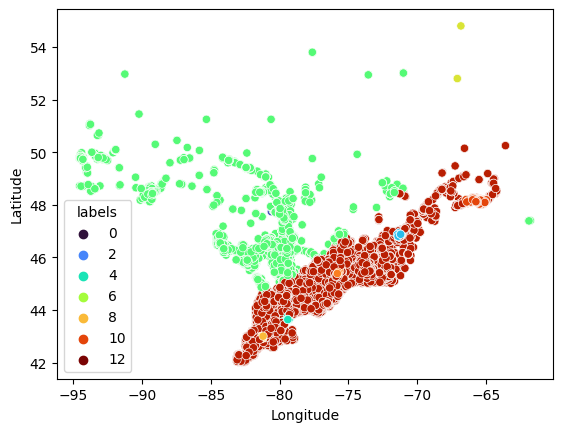

In [14]:
# GMM clusters visualized
sns.scatterplot(x=X1.Longitude, y=X1.Latitude, hue=X1.labels, palette="turbo")

In [ ]:
# Train Gaussian Copula for each cluster
copulas = []
for i in range(num_components):
    copulas.append(GaussianCopula(field_distributions={"NumClaims": "gamma"}))
    copulas[i].fit(X1[X1.labels == i].drop(columns=["labels"]))

In [16]:
# Create fake data
num_fake_data = 250000
fake_data = list()
for i in range(num_components):
    fake_data.append(copulas[i].sample(int(num_fake_data*cluster_weights[i])))
fake_data = pd.concat(fake_data)
# Since this is a zero detector, do not consider rows with number of claims not equal to zero
fake_data = fake_data[fake_data.NumClaims == 0.0]
fake_data["ExpectedSeverity"] = np.nan
fake_data

Latitude  Longitude  AmountOfInsurance  Earnings  BusinessTypeCode  \
0          46.13     -72.86           6.121160  5.044316                 2   
1          45.70     -73.47           6.154608  4.909979                 3   
2          45.99     -72.91           6.085083  4.627609                 4   
3          45.82     -73.37           6.039757  4.872409                 3   
4          45.71     -73.56           6.453286  4.789856                 4   
...          ...        ...                ...       ...               ...   
169558     46.25     -74.13           6.443276  5.016894                19   
169559     44.17     -79.30           6.354343  5.385300                 5   
169560     45.38     -75.58           5.740188  4.840058                23   
169561     43.89     -80.15           5.838838  4.840076                24   
169562     44.12     -75.46           6.545031  5.092523                25   

        AddressCode  NumClaims  ExpectedSeverity  
0                 5        0.0               NaN  
1                 6        0.0               NaN  
2                 6        0.0               NaN  
3                 6        0.0               NaN  
4                 6        0.0               NaN  
...             ...        ...               ...  
169558            0        0.0               NaN  
169559            0        0.0               NaN  
169560            0        0.0               NaN  
169561            0        0.0               NaN  
169562            0        0.0               NaN  

[241588 rows x 8 columns]

#### Create rows with non zero number of claims and some value of expected severity

In [17]:
# ExpectedSeverity model
X2 = train_consolidated_df.copy()
X2 = X2[~X2.ExpectedSeverity.isnull()]
X2

Latitude  Longitude  AmountOfInsurance  Earnings  BusinessTypeCode  \
0        43.90     -79.27           6.694067  4.682131                 8   
1        43.65     -79.43           6.535532  5.147494                14   
2        43.15     -80.24           6.778899  5.497168                25   
3        45.70     -73.63           6.139453  4.997212                23   
4        43.64     -79.76           6.919684  5.513429                23   
...        ...        ...                ...       ...               ...   
8668     45.22     -74.77           6.541751  5.164786                 9   
8669     42.73     -80.96           5.829240  5.247024                 4   
8670     45.60     -73.64           5.816516  4.691348                 3   
8671     46.78     -71.26           6.974666  6.898715                 6   
8672     44.34     -76.34           7.132737  5.976351                27   

      AddressCode  NumClaims  ExpectedSeverity  
0               0        1.0          5.626450  
1               2        1.0          4.940037  
2               0        1.0          5.929975  
3               0        1.0          4.459383  
4               0        1.0          5.385212  
...           ...        ...               ...  
8668            0        1.0          6.152231  
8669            0        1.0          4.105379  
8670            0        1.0          5.459996  
8671            5        1.0          5.232625  
8672            0        1.0          5.557194  

[8472 rows x 8 columns]

<AxesSubplot: xlabel='ExpectedSeverity', ylabel='Count'>

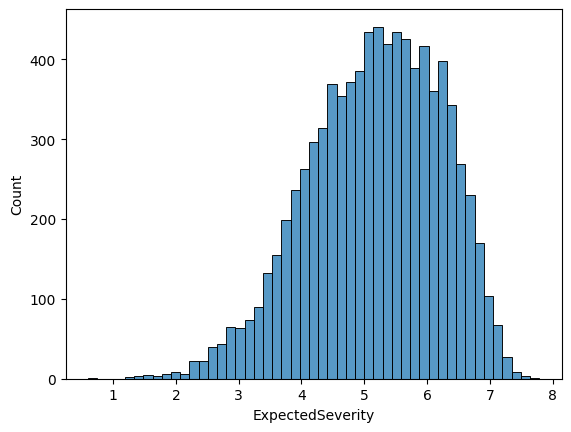

In [18]:
sns.histplot(X2.ExpectedSeverity)

In [19]:
# 14 components result in best BIC
for num_components in range(14, 15):
    gmm = GaussianMixture(n_components=num_components, random_state=1)
    gmm.fit(X2)
    print(f"num components: {num_components}, bic: {gmm.bic(X2)}")

num components: 14, bic: -11388.576490551104


In [20]:
num_components = 14

In [21]:
X2["labels"] = gmm.predict(X2)

In [22]:
cluster_weights = gmm.weights_
cluster_weights

array([8.26052743e-04, 5.57192106e-02, 4.08404168e-02, 1.18050856e-03,
       1.73515565e-02, 2.36034878e-03, 2.26076023e-02, 2.60874292e-02,
       1.51638824e-02, 7.08215103e-04, 1.02924121e-02, 1.66415630e-02,
       7.73208956e-01, 1.70118457e-02])

In [ ]:
# Train Gaussian Copula for each cluster
copulas = []
for i in range(num_components):
    copulas.append(GaussianCopula())
    copulas[i].fit(X2[X2.labels == i].drop(columns=["labels"]))

In [24]:
# Create fake data
num_fake_data = 8500
fake_data_1 = list()
for i in range(num_components):
    fake_data_1.append(copulas[i].sample(int(num_fake_data*cluster_weights[i])))
fake_data_1 = pd.concat(fake_data_1)
fake_data_1 = fake_data_1
fake_data_1

Latitude  Longitude  AmountOfInsurance  Earnings  BusinessTypeCode  \
0       47.11     -78.57           6.287498  5.263844                 1   
1       45.20     -84.24           6.377974  5.336289                 0   
2       43.61     -79.91           6.681655  4.696123                 0   
3       43.72     -79.55           6.632925  4.949723                 1   
4       45.72     -82.90           6.312259  5.111579                 1   
..        ...        ...                ...       ...               ...   
139     48.07     -65.66           5.037975  4.421773                21   
140     48.05     -65.32           6.828678  5.559787                21   
141     48.20     -65.64           6.120217  5.592596                17   
142     48.19     -65.88           6.166195  5.191734                 3   
143     48.08     -65.67           6.732128  6.197776                26   

     AddressCode  NumClaims  ExpectedSeverity  
0              0        2.0          5.337292  
1              0        2.0          6.433216  
2              0        3.0          6.218019  
3              0        3.0          4.592805  
4              0        2.0          6.155266  
..           ...        ...               ...  
139            0        1.0          3.222133  
140            0        1.0          5.175067  
141            0        1.0          3.999245  
142            0        1.0          4.954084  
143            0        1.0          5.130736  

[8495 rows x 8 columns]

#### Merge both the fake data tables to get the final fake data table

In [30]:
final_fake_data = pd.concat([fake_data, fake_data_1])
final_fake_data = final_fake_data.reset_index(drop=True)
final_fake_data

Latitude  Longitude  AmountOfInsurance  Earnings  BusinessTypeCode  \
0          46.13     -72.86           6.121160  5.044316                 2   
1          45.70     -73.47           6.154608  4.909979                 3   
2          45.99     -72.91           6.085083  4.627609                 4   
3          45.82     -73.37           6.039757  4.872409                 3   
4          45.71     -73.56           6.453286  4.789856                 4   
...          ...        ...                ...       ...               ...   
250078     48.07     -65.66           5.037975  4.421773                21   
250079     48.05     -65.32           6.828678  5.559787                21   
250080     48.20     -65.64           6.120217  5.592596                17   
250081     48.19     -65.88           6.166195  5.191734                 3   
250082     48.08     -65.67           6.732128  6.197776                26   

        AddressCode  NumClaims  ExpectedSeverity  
0                 5        0.0               NaN  
1                 6        0.0               NaN  
2                 6        0.0               NaN  
3                 6        0.0               NaN  
4                 6        0.0               NaN  
...             ...        ...               ...  
250078            0        1.0          3.222133  
250079            0        1.0          5.175067  
250080            0        1.0          3.999245  
250081            0        1.0          4.954084  
250082            0        1.0          5.130736  

[250083 rows x 8 columns]

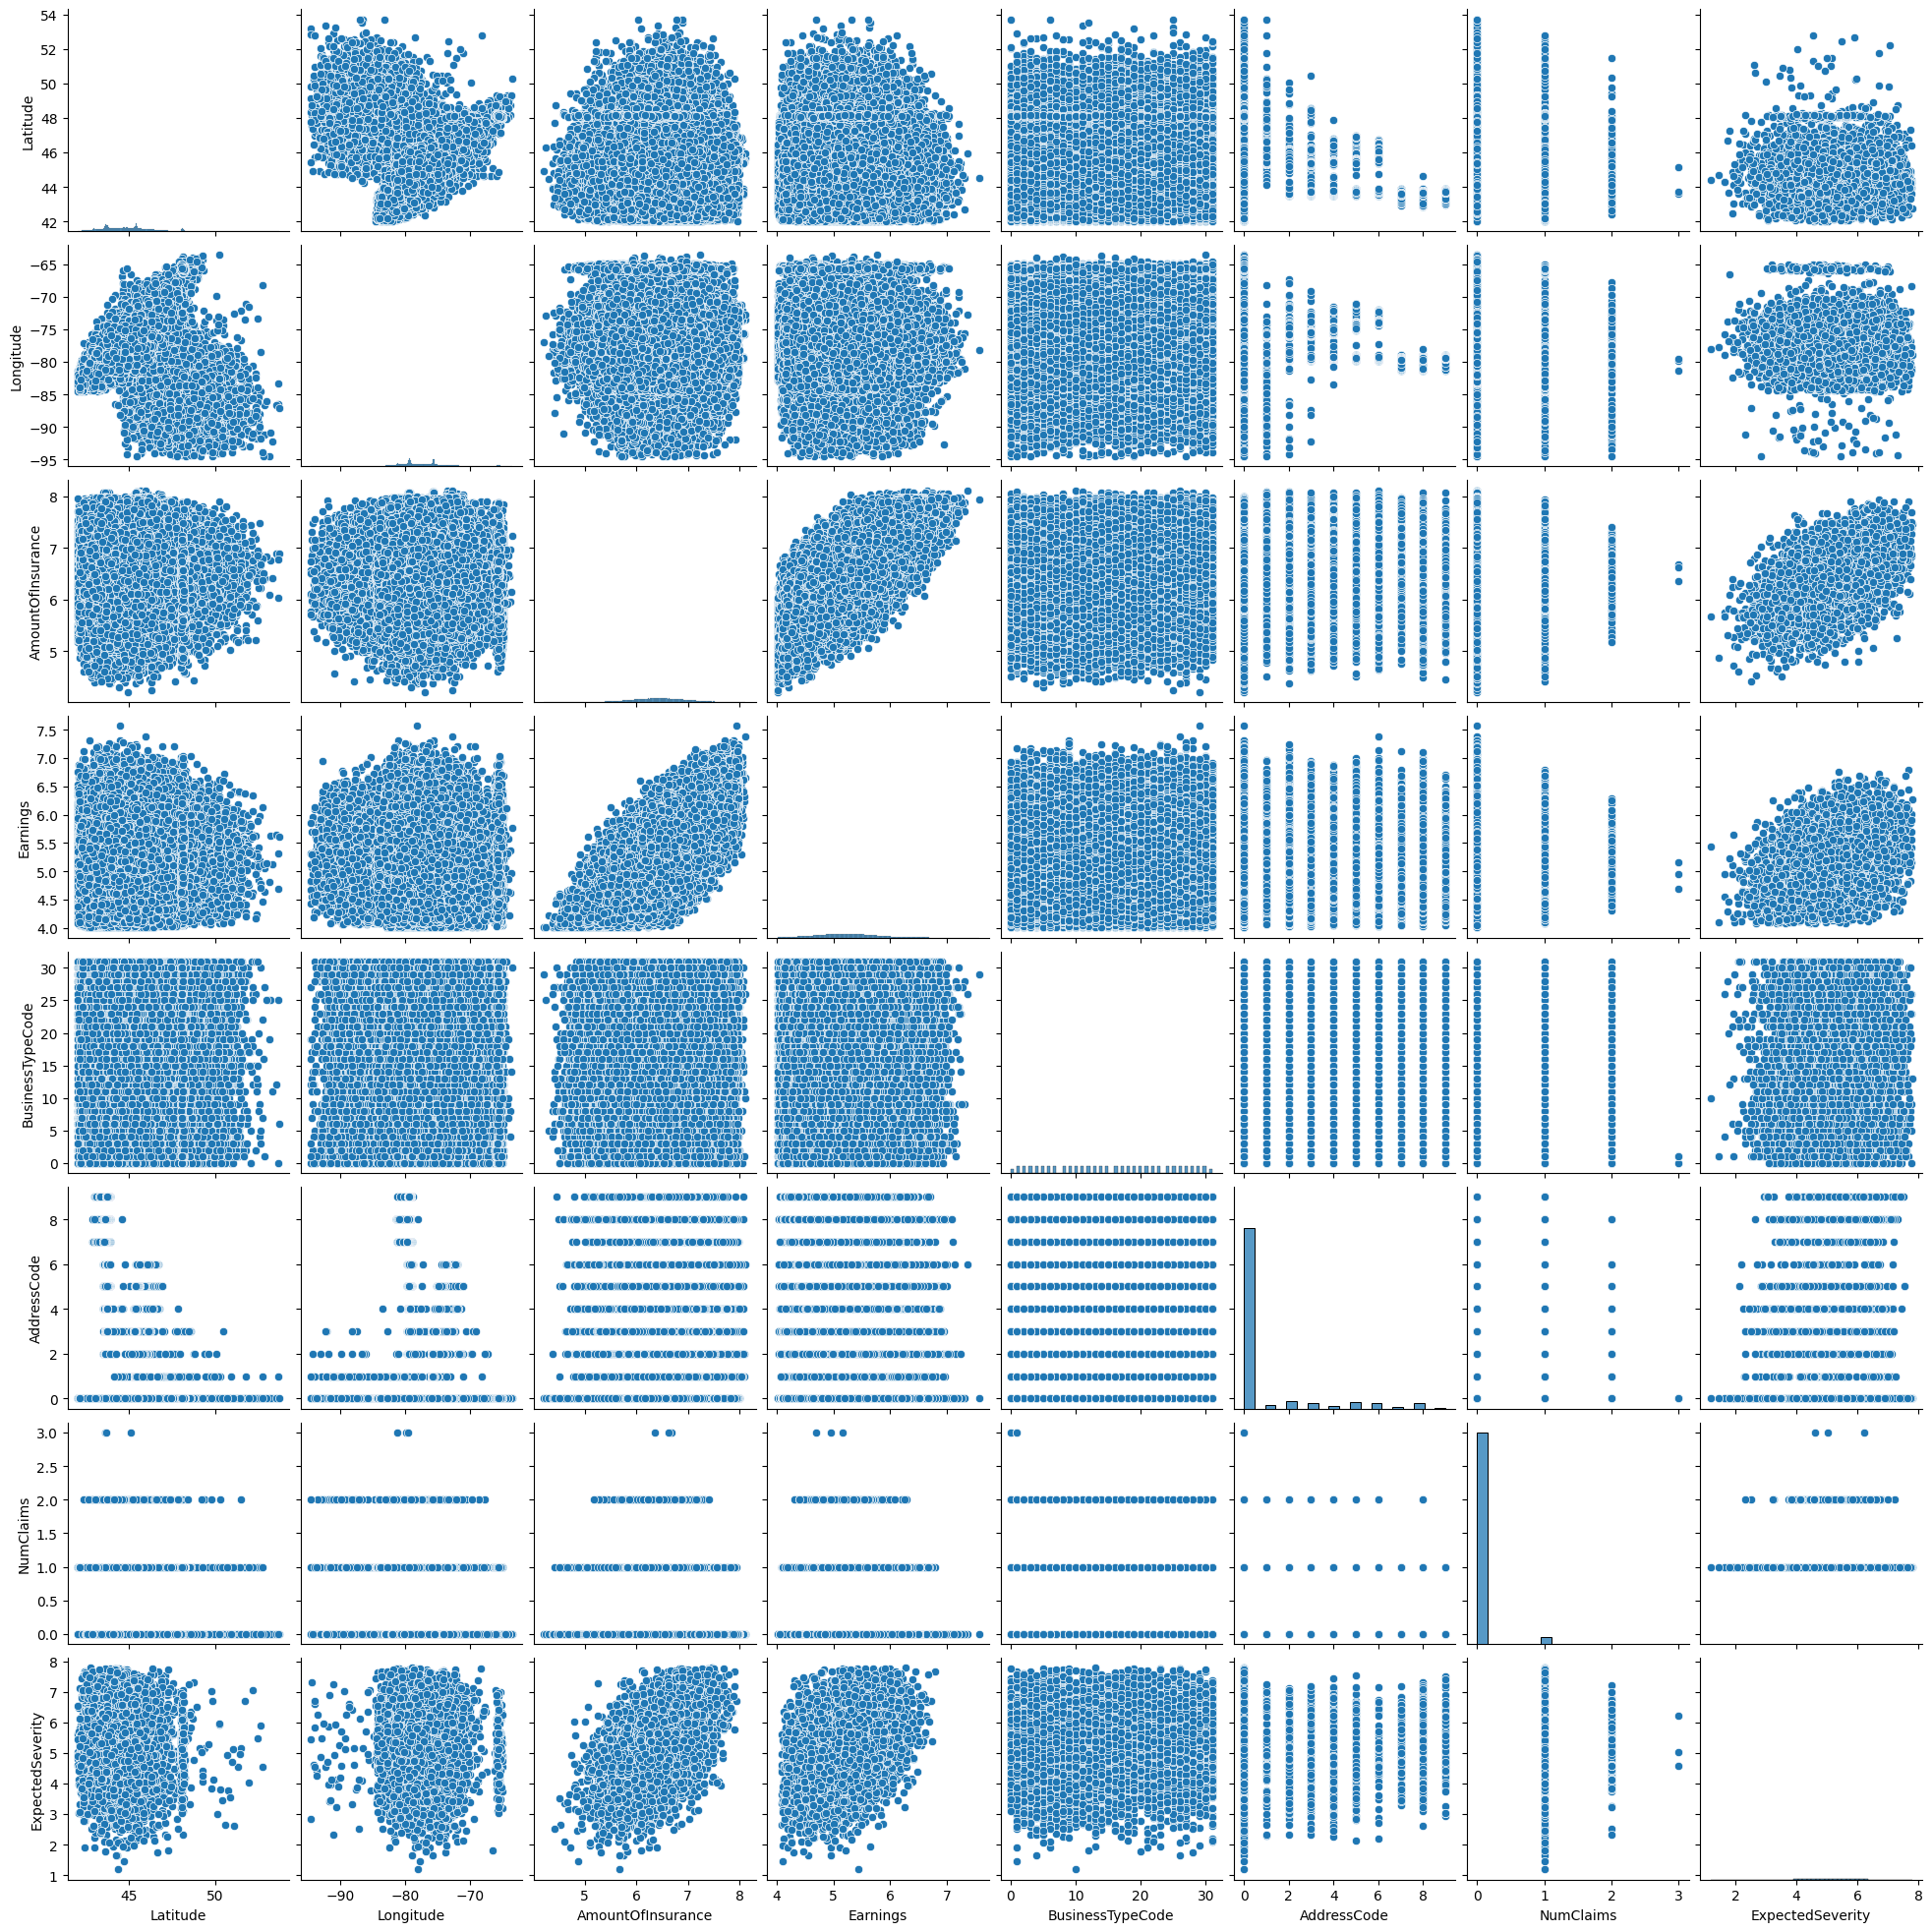

In [31]:
sns.pairplot(final_fake_data)

In [37]:
final_fake_data.to_csv("fake_data.csv", index=False)